# Exponential Smoothing Methods

## 1. Simple Exponential Smoothing

$$
\hat{y}_{T+1|T}=\alpha y_T+\alpha(1-\alpha)y_{T-1}+\alpha(1-\alpha)^2 y_{T-2}+\cdots \qquad(0 \leq \alpha \leq 1)
$$

### Weighted average form

$$\hat{y}_{T+1|T}=\alpha y_T+\alpha(1-\alpha)y_{T-1}+\alpha(1-\alpha)^2 y_{T-2}+\cdots$$

$$\hat{y}_{T+1|T}=\alpha y_T+(1-\alpha)\{\alpha y_T + \alpha(1-\alpha)y_{T-2}+\cdots\}$$

$$\hat{y}_{T+1|T}=\alpha y_T+(1-\alpha)\hat{y}_{T|T-1}$$

- The process has to start somewhere, so we let the first fitted value at time 1 be denoted by $\ell_0$.

$$\hat{y}_{2|1} = \alpha y_1 + (1 - \alpha)\ell_0$$

$$\hat{y}_{3|2} = \alpha y_2 + (1 - \alpha)\hat{y}_{2|1}$$

$$\vdots$$

$$\hat{y}_{T|T-1} = \alpha y_{T-1} + (1 - \alpha)\hat{y}_{T-1|T-2}$$

$$\hat{y}_{T+1|T} = \alpha y_T + (1 - \alpha)\hat{y}_{T|T-1}$$

### Component form

$$
\begin{aligned}
\text{Forecast equation} &: \hat{y}_{t+h|t} = \ell_t \\
\text{Smoothing equation} &: \ell_t = \alpha y_t + (1 - \alpha)\ell_{t-1}
\end{aligned}
$$

- All forecast take the same value, equal to the last level component.

$$
\begin{aligned}
1.\quad \hat{y}_{T+1|T} &= \ell_T \\
2.\quad \hat{y}_{T+2|T} &= \hat{\ell}_{T+1} \\
                        &= \alpha \hat{y}_{T+1} + (1 - \alpha) \ell_t \\
                        &= \alpha \ell_t + (1 - \alpha) \ell_t \\
                        &= \ell_t
\end{aligned}
$$

### Optimization

- We need to select $\alpha$ and $\ell_0$.

- We find the values of the unknown parameters and the initial values that minimize

$$
\text{SSE} = \sum_{t=1}^T \left(y_t - \hat{y}_{t|t-1} \right)^2 = \sum_{t=1}^T e_t^2
$$

### (1) Simple Exponential Smoothing assumes that the data has been detrended and deasonlized

In [64]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

<Axes: xlabel='Month'>

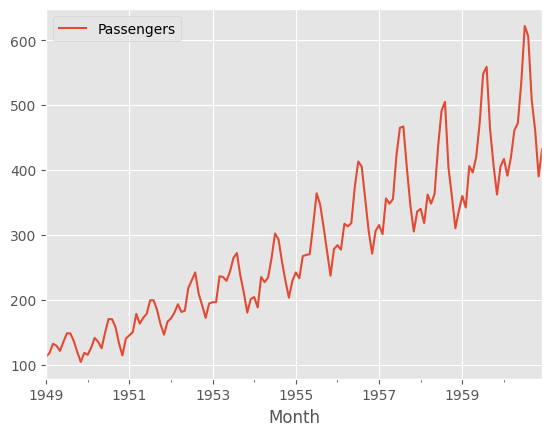

In [65]:
plt.style.use('ggplot')
df = pd.read_csv('../data/air_passengers.csv')
df.set_index('Month', inplace=True)
df.index = pd.to_datetime(df.index)

# drop null values
df.dropna(inplace=True)

df.plot()

### (1)-1 Moving Average Smoothing

$$
\hat{T}_t = \frac{1}{m} \sum_{j=-k}^{k} y_{t+j}, \quad
\text{where } k = \frac{m - 1}{2}
$$

- 7 - MA: Daily data with a weekly seasonality

$$
\hat{T}_t = \frac{1}{7} (y_{t-3} + y_{t-2} + y_{t-1} + y_t + y_{t+1} + y_{t+2} + y_{t+3})
$$

- 만약 seasonal period가 짝수일 경우 중심점을 기준으로 정확히 대칭이 되지 않기 때문에 2 $\times$ m - MA를 사용한다.
- 2 $\times$ 12 - MA: monthly data with annual seasonality

$$
\begin{aligned}
\hat{T}_t = \frac{1}{2} 
(\frac{1}{12} (y_{t-6} + y_{t-5} + y_{t-4} + y_{t-3} + y_{t-2} + y_{t-1} + y_{t} + y_{t+1} + y_{t+2} + y_{t+3} + y_{t+4} + y_{t+5}) \\
+ \frac{1}{12} (y_{t-5} + y_{t-4} + y_{t-3} + y_{t-2} + y_{t-1} + y_{t} + y_{t+1} + y_{t+2} + y_{t+3} + y_{t+4} + y_{t+5} + y_{t+6}))
\end{aligned}
$$

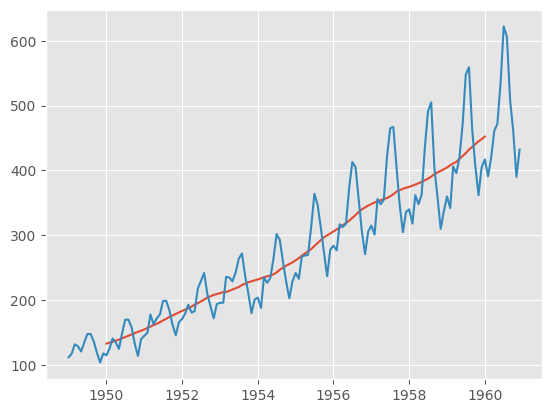

In [66]:
ma_trend = df.rolling(window=24, center=True).mean()
plt.plot(ma_trend)
plt.plot(df)

### (1)-2 Time Series Decomposition

Step 1
- Estimate $\hat{T}_t$ using $(2 \times m)$-MA if $m$ is even.  
- Otherwise estimate $\hat{T}_t$ using $m$-MA.

Step 2
- Calculate the de-trended series: $y_t - \hat{T_t}$

Step 3
- Calculate $\hat{S_t}$
- To estimate the seasonal component for each season, simply averave the de-trended values for that season.
- Seasonal component values are the adjusted to ensure that they add to zero. (option)

Step 4
- Calculate $\hat{R_t}$
- $\hat{R_t} = y_t - \hat{Y_t} - \hat{S_t}$

In [67]:
result = seasonal_decompose(df.Passengers, model='additive', period=12)

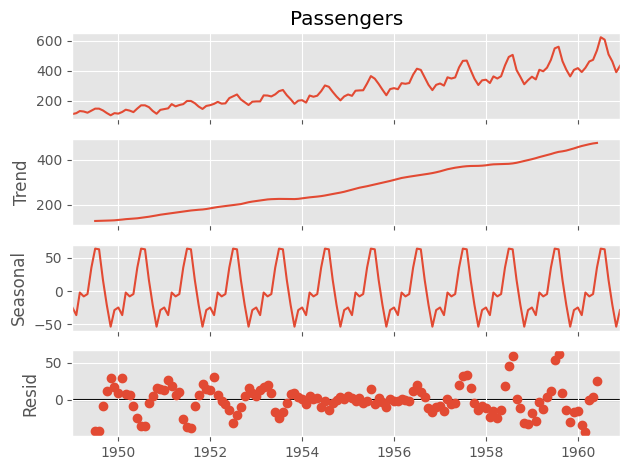

In [68]:
result.plot();

### (2) Remove trend + seasonality

In [69]:
df_removed = df.Passengers - result.seasonal - result.trend
df_removed = df_removed.dropna()

<Axes: xlabel='Month'>

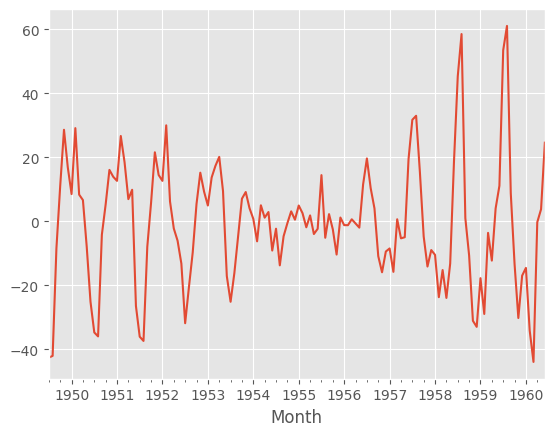

In [70]:
df_removed.plot()

### (3) Simple Exponential Smoothing using Statsmodels package

In [71]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(df_removed)
model1 = ses.fit(smoothing_level=0.2, optimized=False)
model2 = ses.fit(smoothing_level=0.8, optimized=False)
model3 = ses.fit(optimized=True)

c:\Users\PC\Desktop\명수의 공부자료\대학교 강의\시계열분석및예측\Github\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [72]:
print(model1.params["smoothing_level"])
print(model2.params["smoothing_level"])
print(model3.params["smoothing_level"])

0.2
0.8
0.9999999850988129


<Axes: xlabel='Month'>

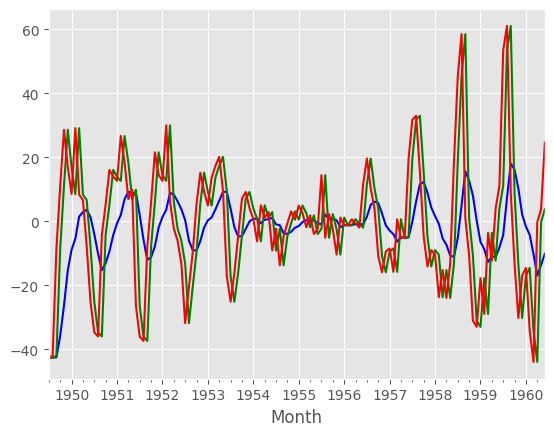

In [73]:
model1.fittedvalues.plot(color='blue')
model3.fittedvalues.plot(color='green')
df_removed.plot(color='red')

### (4) 3-Step ahead forecast

In [74]:
fcast1 = model1.forecast(3).rename(r"$\alpha=0.2$")
fcast2 = model2.forecast(3).rename(r"$\alpha=0.8$")
fcast3 = model3.forecast(3).rename(r"$\alpha=%s$" % model3.params["smoothing_level"])

### (5) Plot the result

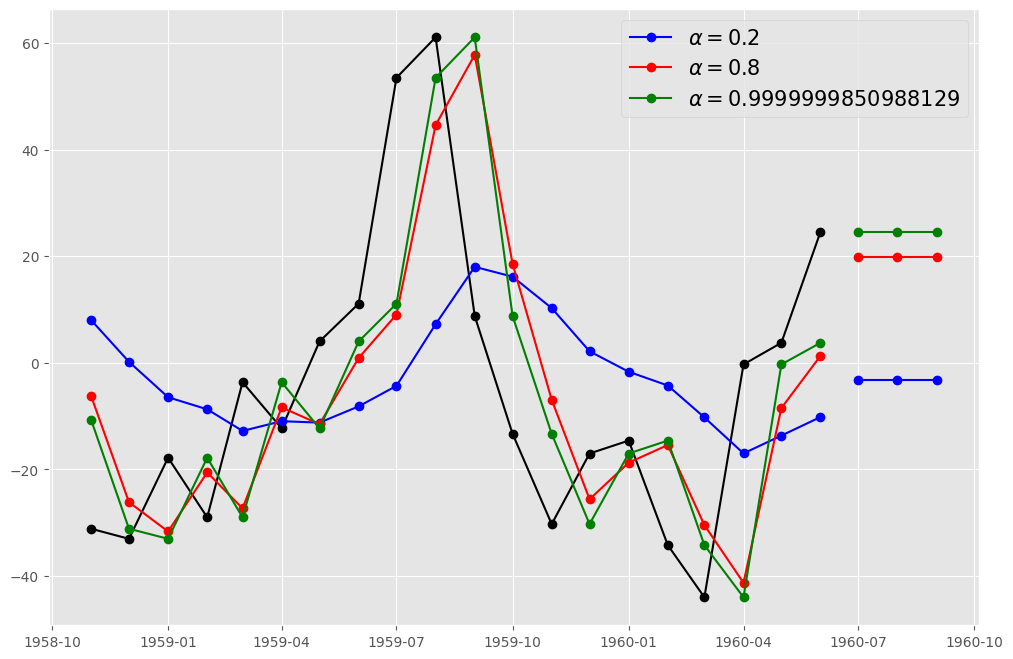

In [75]:
plt.figure(figsize=(12, 8))
plt.plot(df_removed[-20:], marker="o", color="black")
plt.plot(model1.fittedvalues[-20:], marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(model2.fittedvalues[-20:], marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(model3.fittedvalues[-20:], marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name],fontsize="15")

## 2. Holt's linear trend method

-  Holt (1957) extended simple exponential smoothing to allow the forecasting of data with a trend.

$$
\begin{aligned}
\text{Forecast equation} &: \hat{y}_{t+h|t}=\ell_t+hb_t \\
\text{Level equation} &: \ell_t=\alpha y_t+(1-\alpha)(\ell_{t-1}+b_{t-1}) \\
\text{Trend equation} &: b_t=\beta^*(\ell_t-\ell_{t-1})+(1-\beta^*)b_{t-1}
\end{aligned}
$$

$$
\begin{aligned}
1.\quad \hat{y}_{T+1|T} &= \ell_T + b_T \\
2.\quad \hat{y}_{T+2|T} &= \hat{\ell}_{T+1} + \hat{b}_{T+1} \\
                        &= \alpha \hat{y}_{T+1} + (1 - \alpha)(\ell_T + b_T) + \beta^*(\hat{\ell}_{T+1} - \ell_T) + (1 - \beta^*) b_T \\
                        &= \ell_T + b_T + \beta^*(\hat{\ell}_{T+1} - \ell_T) + (1 - \beta^*) b_T \quad \because \hat{y}_{T+1|T} = \ell_T + b_T \\
                        &= \ell_T + b_T + b_T \quad \because \hat{\ell}_{t+1} = \ell_T + b_T \\
                        &= \ell_T + 2b_T
\end{aligned}
$$

### (1) We need the data to have trend, so deasonalize only

In [76]:
df_deseasonalized = df.Passengers - result.seasonal
df_deseasonalized.dropna()

Month
1949-01-01    136.748737
1949-02-01    154.188131
1949-03-01    134.241162
1949-04-01    137.036616
1949-05-01    125.506313
                 ...    
1960-08-01    543.176768
1960-09-01    491.479798
1960-10-01    481.642677
1960-11-01    443.593434
1960-12-01    460.619949
Length: 144, dtype: float64

<Axes: xlabel='Month'>

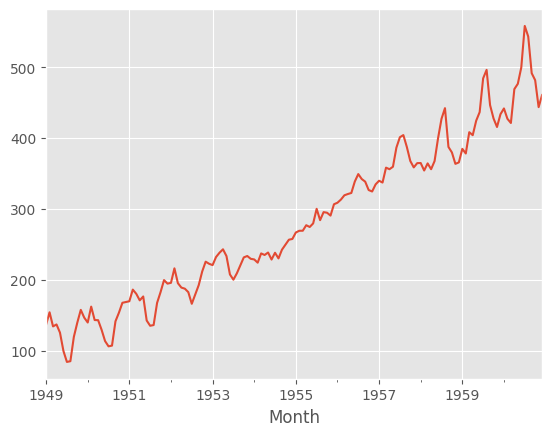

In [77]:
df_deseasonalized.plot()

### (2) Fit the model using Holt's Method

In [78]:
from statsmodels.tsa.api import Holt

Holt1 = Holt(df_deseasonalized, initialization_method='estimated').fit(
    smoothing_level=0.9, smoothing_trend=0.1, optimized=False
)
Holt2 = Holt(df_deseasonalized, initialization_method='estimated').fit()

c:\Users\PC\Desktop\명수의 공부자료\대학교 강의\시계열분석및예측\Github\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\PC\Desktop\명수의 공부자료\대학교 강의\시계열분석및예측\Github\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


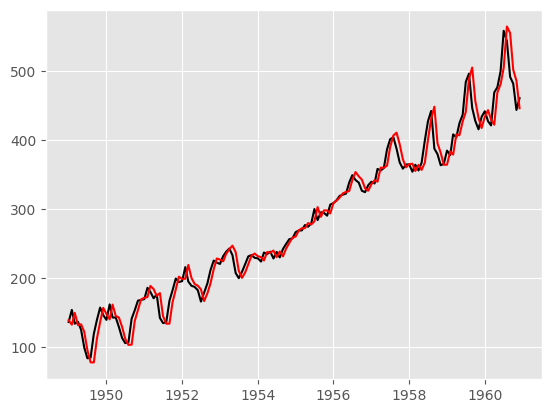

In [79]:
plt.plot(df_deseasonalized, color='black')
plt.plot(Holt1.fittedvalues, color='red')
#plt.plot(Holt2.fittedvalues,color='green')

In [80]:
print(Holt2.params['smoothing_level'])
print(Holt2.params['smoothing_trend'])

0.9999999850974077
5.3442240108504054e-14


### (3) 5-step ahead forecast

In [81]:
fcast1 = Holt1.forecast(5).rename(r"$\alpha=0.9, \Phi=0.1$")
fcast2 = Holt2.forecast(5).rename(r"$\alpha=%s, \Phi=%s$"%(Holt2.params["smoothing_level"], Holt2.params["smoothing_trend"]))

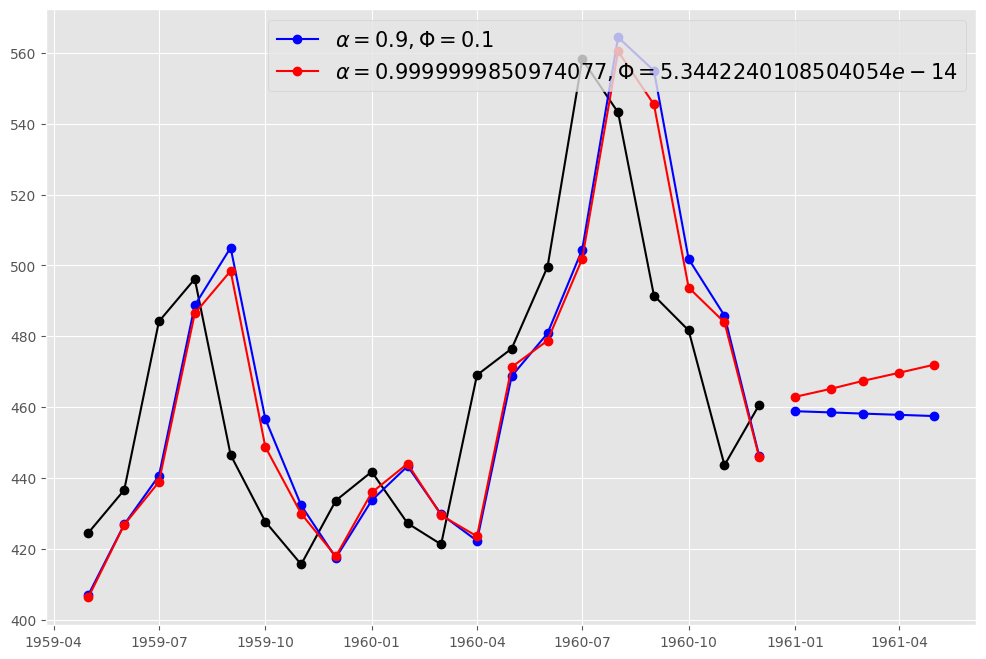

In [82]:
plt.figure(figsize=(12, 8))
plt.plot(df_deseasonalized[-20:], marker="o", color="black")
plt.plot(Holt1.fittedvalues[-20:], marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(Holt2.fittedvalues[-20:], marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.legend([line1, line2], [fcast1.name, fcast2.name],fontsize="15")

### (4) Dampend Trend

- Holt's linear trend method display a constant trend (increasing or decreasing) indefinitely into the future.

- These methods tend to over-forecast, especially for longer forecast horizons.

- Gardner & McKenzie (1985) introduced a parameter that “dampens” the trend to a flat line some 
time in the future.

- Methods that include a damped trend have proven to be very successful, and arguably the most popular individual methods when forecasts are required automatically for many series.

- In conjunction with the smoothing parameters $\alpha$ and $\beta^*$, this method also includes a damping parameter $0 < \phi < 1$:

$$
\begin{aligned}
\text{Forecast equation} &: \hat{y}_{t+h|t}=\ell_t+(\phi+\phi^2+\cdots+\phi^h)b_t \\
\text{Level equation} &: \ell_t=\alpha y_t+(1-\alpha)(\ell_{t-1}+\phi b_{t-1}) \\
\text{Trend equation} &: b_t=\beta^*(\ell_t-\ell_{t-1})+(1-\beta^*)\phi b_{t-1}
\end{aligned}
$$

- If $\phi=1$, the method is identical to Holt's linear method.

- The forecasts converge to $\ell_T + \phi b_T/(1-\phi)$ as $h \to \infty$ 

- Short-run forecasts are trended while long-run forecasts are constant.

In [83]:
Holt3 = Holt(df_deseasonalized, initialization_method='estimated', damped_trend=True).fit()

c:\Users\PC\Desktop\명수의 공부자료\대학교 강의\시계열분석및예측\Github\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [84]:
fcast3 = Holt3.forecast(5).rename(r"Additive damped trend")

In [85]:
Holt3.params

{'smoothing_level': 0.9999488073406181,
 'smoothing_trend': 2.4711213983116597e-05,
 'smoothing_seasonal': nan,
 'damping_trend': 0.8005675240481186,
 'initial_level': 138.813129966573,
 'initial_trend': -3.544720137406107,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

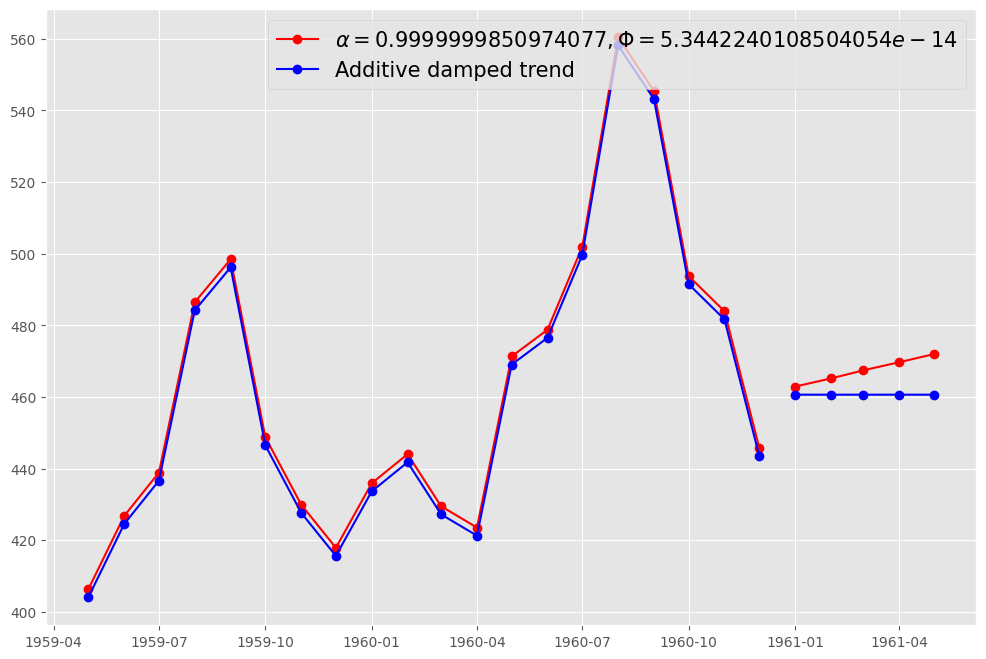

In [86]:
plt.figure(figsize=(12, 8))
plt.plot(Holt2.fittedvalues[-20:], marker="o", color="red")
(line1,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(Holt3.fittedvalues[-20:], marker="o", color="Blue")
(line2,) = plt.plot(fcast3, marker="o", color="Blue")
plt.legend([line1, line2], [fcast2.name, fcast3.name],fontsize="15")

## Holt-Winters Seasonal Method

### Additive Method
$$
\begin{aligned}
\text{Forecast equation} &: \hat{y}_{t+h|t}=\ell_t+hb_t+s_{t+h-m(k+1)} \\
\text{Level equation} &: \ell_t=\alpha (y_t-s_{t-m})+(1-\alpha)(\ell_{t-1}+b_{t-1}) \\
\text{Trend equation} &: b_t=\beta^*(\ell_t-\ell_{t-1})+(1-\beta^*)b_{t-1} \\
\text{Seasonality equation} &: s_t=\gamma(y_t-\ell_{t-1}-b_{t-1})+(1-\gamma)s_{t-m} 
\end{aligned}
$$
- m denote the period of seasonality
- k is the integer part of $ (h-1) / m$

### Multiplicative Method
$$
\begin{aligned}
\text{Forecast equation} &: \hat{y}_{t+h|t}=(\ell_t+hb_t)s_{t+h-m(k+1)} \\
\text{Level equation} &: \ell_t=\alpha \frac{y_t}{s_{t-m}}+(1-\alpha)(\ell_{t-1}+b_{t-1}) \\
\text{Trend equation} &: b_t=\beta^*(\ell_t-\ell_{t-1})+(1-\beta^*)b_{t-1} \\
\text{Seasonality equation} &: s_t=\gamma \frac{y_t}{\ell_{t-1}+b_{t-1}}+(1-\gamma)s_{t-m}
\end{aligned}
$$

## Holt-Winters' Damped Method

$$
\begin{aligned}
\text{Forecast equation} &: \hat{y}_{t+h|t} = [ \ell_t + (\phi + \phi^2 + \cdots + \phi^h)b_t ] s_{t+h - m(k+1)} \\
\text{Level equation} &: \ell_t = \alpha \frac{y_t}{s_{t-m}} + (1 - \alpha)(\ell_{t-1} + \phi b_{t-1}) \\
\text{Trend equation} &: b_t = \beta^*(\ell_t - \ell_{t-1}) + (1 - \beta^*)\phi b_{t-1} \\
\text{Seasonality equation} &: s_t = \gamma \frac{y_t}{\ell_{t-1} + \phi b_{t-1}} + (1 - \gamma)s_{t-m}
\end{aligned}
$$

### (1) Use the original data

<Axes: xlabel='Month'>

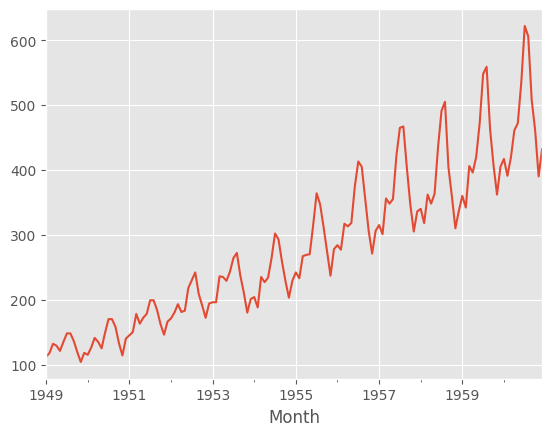

In [87]:
df.Passengers.plot()

### (2) (Trend, Seasonal) Model: ex. (A, A), (A, M)


| Trend \ Seasonal        | N (None) | A (Additive) | M (Multiplicative) |
|-------------------------|----------|--------------|---------------------|
| **N (None)**            | (N,N)    | (N,A)        | (N,M)               |
| **A (Additive)**        | (A,N)    | (A,A)        | (A,M)               |
| **Aₙ (Additive damped)**| (A<sub>d</sub>,N)   | (A<sub>d</sub>,A)       | (A<sub>d</sub>,M)              |

---

| **Short hand**        | **Method**                              |
|-----------------------|------------------------------------------|
| (N,N)                 | Simple exponential smoothing             |
| (A,N)                 | Holt’s linear method                     |
| (A<sub>d</sub>,N)     | Additive damped trend method             |
| (A,A)                 | Additive Holt-Winters’ method            |
| (A,M)                 | Multiplicative Holt-Winters’ method      |
| (A<sub>d</sub>,M)     | Holt-Winters’ damped method              |


### Use season_length=12, Box-Cox transformation

- Box-Cox Transformation

$$
w_t =
\begin{cases}
\ln y_t, & \lambda = 0 \\
\frac{y_t^\lambda - 1}{\lambda}, & \lambda \ne 0
\end{cases}
$$

$$
w_t =
\begin{cases}
\ln y_t, & \lambda = 0 \\
\frac{\operatorname{sign}(y_t) \cdot |y_t|^\lambda - 1}{\lambda}, & \lambda \ne 0
\end{cases}
$$

In [88]:
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(df.Passengers, seasonal_periods=12, trend="add", seasonal="add", use_boxcox=True, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(df.Passengers, seasonal_periods=12, trend="add", seasonal="mul", use_boxcox=True, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(df.Passengers, seasonal_periods=12, trend="add", seasonal="add", damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(df.Passengers, seasonal_periods=12, trend="add", seasonal="mul", damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()

c:\Users\PC\Desktop\명수의 공부자료\대학교 강의\시계열분석및예측\Github\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\PC\Desktop\명수의 공부자료\대학교 강의\시계열분석및예측\Github\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\PC\Desktop\명수의 공부자료\대학교 강의\시계열분석및예측\Github\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\PC\Desktop\명수의 공부자료\대학교 강의\시계열분석및예측\Github\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [89]:
results = pd.DataFrame(index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$","SSE"])
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Add Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multi Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

In [90]:
results

,Additive,Multiplicative,Add Dam,Multi Dam
$\alpha$,0.346769,3.668048e-01,3.558163e-01,3.755172e-01
$\beta$,0.000000,2.066238e-17,4.928243e-13,1.667437e-11
$\phi$,NaN,NaN,9.950000e-01,9.950000e-01
$\gamma$,0.554848,4.246248e-01,5.595984e-01,4.393217e-01
$l_0$,6.975608,7.028241e+00,6.961744e+00,7.026110e+00
$b_0$,0.022098,2.235649e-02,3.024615e-02,3.059656e-02
SSE,16572.799758,1.599782e+04,1.682527e+04,1.624202e+04


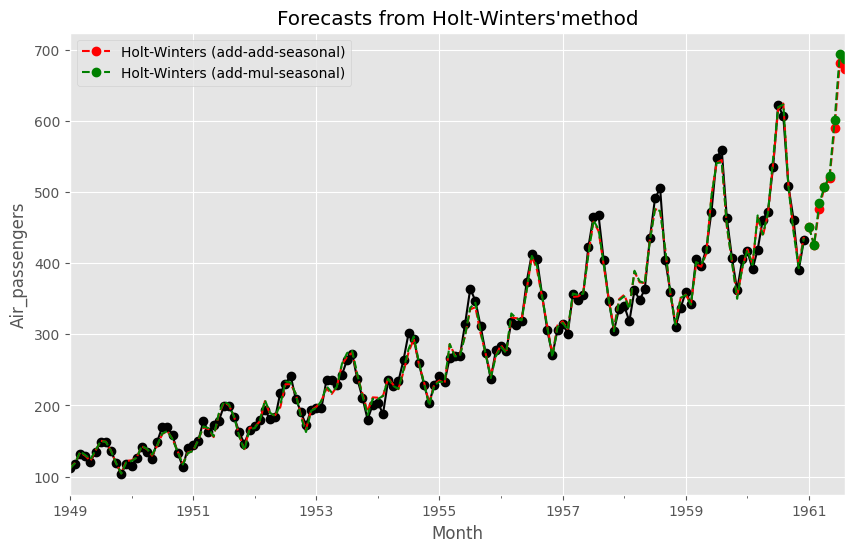

In [91]:
ax = df.Passengers.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters'method",
)
ax.set_ylabel("Air_passengers")
ax.set_xlabel("Month")
fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()

### (3) Simulations with additive errors

- Recall the component form of simple exponential smoothing:
$$
\begin{aligned}
\text{Forecast equation} &: \ell_t \\
\text{Smoothing equation} &: \ell_t = \alpha y_t + (1 - \alpha)\ell_{t-1}
\end{aligned}
$$

- If we re-arrange the smoothing equation for the level, we get the "error correction" form.
$$
\begin{aligned}
& \ell_t = \ell_{t-1} + \alpha (y_t - \ell_{t-1}) = \ell_{t-1} + \alpha e_t \\
& where\ e_t = y_t - \ell_{t-1} = y_t - \hat{y}_{t|t-1}
\end{aligned}
$$

In [92]:
fit = ExponentialSmoothing(
    df.Passengers,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    initialization_method="estimated",
).fit()
simulations = fit.simulate(8, repetitions=100, error="add")

c:\Users\PC\Desktop\명수의 공부자료\대학교 강의\시계열분석및예측\Github\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


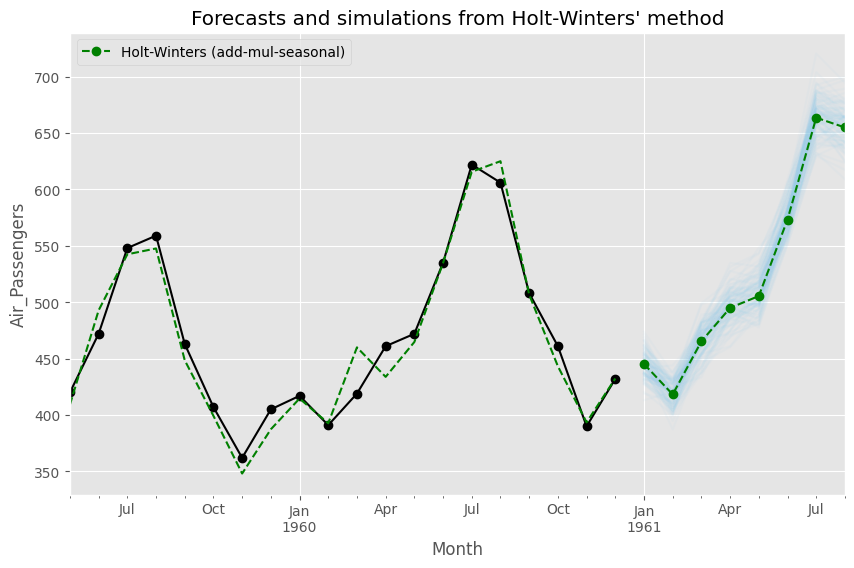

In [93]:
ax = df.Passengers[-20:].plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' method",
)
ax.set_ylabel("Air_Passengers")
ax.set_xlabel("Month")
fit.fittedvalues[-20:].plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="skyblue", legend=False)
fit.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show()